# tldr; Completion rate(**) has gone up by ~0.75% from FY2016_Q4 to FY2017_Q1. This is driven by a higher percentage of enrollments which are verified, with verified enrollments having a higher completion rate compared with non-verified enrollments.

* * *

### **loads of assumptions here:
#### Instructor led courses only, as certificates aren't automatically granted for self paced.
#### Assuming that all certificates have been processed for Q1 2017 as of today, 10/21. 21 days should be long enough, but FYI.
#### Attribution of course completion is based on the course end date. If the course end date fell in FY2017_Q1, a learner's completion is attributed to that time period, regardless of the enrollment time.

In [4]:
import pandas as pd
import vertica_python
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import os

In [5]:
username = os.getenv('VERTICA_USERNAME')
password = os.getenv('VERTICA_PASSWORD')
conn_info = {'host': 'warehouse.analytics.edx.org',
             'port': 5433,
             'user': username,
             'password': password,
             'database': 'warehouse',
             'read_timeout': 600,
             'unicode_error': 'strict',
             'ssl': False}

# Queries
* * *
### Overall Completion Rate

In [6]:
#DROP TABLE IF EXISTS ahemphill.completion_rate;
#CREATE TABLE ahemphill.completion_rate AS
#	SELECT
#		a.user_id,
#		a.course_id,
#		a.current_enrollment_mode,
#		a.first_enrollment_mode,
#		a.first_enrollment_time,
#		b.catalog_course_title,
#		b.end_time AS end_time_from_d_course,
#		c.enddate AS end_time_ed_services_table,
#		d.certificate_mode,
#		d.has_passed,
#		CASE WHEN b.end_time BETWEEN '2016-04-01' AND '2016-07-01' THEN 'Q4_2016' ELSE 'Q1_2017' END AS quarter_d_course,
#		CASE WHEN c.enddate BETWEEN '2016-04-01' AND '2016-07-01' THEN 'Q4_2016' ELSE 'Q1_2017' END AS quarter_ed_services
#	FROM
#		production.d_user_course a	
#	LEFT JOIN
#		production.d_course b
#	ON
#	       a.course_id = b.course_id
#	LEFT JOIN
#	       ed_services.CourseCatalog_20161010 c
#	ON
#	       a.course_id = c.CourseID
#	LEFT JOIN
#	    production.d_user_course_certificate d
#	ON     
#	    a.user_id = d.user_id
#	    AND a.course_id = d.course_id#
#	WHERE
#		b.pacing_type = 'instructor_paced'
#		AND c.enddate BETWEEN '2016-04-01' AND '2016-10-01'
#		AND a.first_enrollment_time <= c.enddate
#		AND a.first_enrollment_time IS NOT NULL


In [7]:
completion_rate_overall_query = """

SELECT
	c.quarter_ed_services AS quarter,
	SUM(c.has_passed)*100.0/COUNT(1) AS completion_percentage,
	SUM(c.has_passed) AS total_completions,
	COUNT(1) AS total_enrollments
FROM ahemphill.completion_rate c
GROUP BY 
	c.quarter_ed_services

"""

### Completion Rate by Course

In [8]:
completion_rate_by_course_query = """

SELECT
	c.quarter_ed_services AS quarter,
	c.course_id,
	c.catalog_course_title,
	SUM(c.has_passed)*100.0/COUNT(1) AS completion_percentage,
	SUM(c.has_passed) AS total_completions,
	COUNT(1) AS total_enrollments
FROM ahemphill.completion_rate c
GROUP BY 
	c.quarter_ed_services,
    c.course_id,
    c.catalog_course_title

"""

In [48]:
completion_rate_by_course_query_w_program = """
SELECT
	c.quarter_ed_services AS quarter,
	c.course_id,
	c.catalog_course_title,
	p.program_type,
    s.subject_title,
   CASE WHEN c.current_enrollment_mode IN ('honor','audit') THEN 'honor/audit' ELSE c.current_enrollment_mode END AS certificate_mode,
	
	SUM(c.has_passed)*100.0/COUNT(1) AS completion_percentage,
	SUM(c.has_passed) AS total_completions,
	COUNT(1) AS total_enrollments
FROM ahemphill.completion_rate c
LEFT JOIN production.d_program_course p
ON c.course_id = p.course_id
LEFT JOIN production.d_course_subjects s
ON c.course_id = s.course_id
GROUP BY 
	1,2,3,4,5,6
"""

### Completion Rate by Course and Course Cert

In [49]:
completion_rate_by_course_cert_query = """

SELECT
	c.quarter_ed_services AS quarter,
	c.course_id,
	c.catalog_course_title,
    CASE WHEN c.current_enrollment_mode IN ('honor','audit') THEN 'honor/audit' ELSE c.current_enrollment_mode END AS certificate_mode,
	SUM(c.has_passed)*100.0/COUNT(1) AS completion_percentage,
	SUM(c.has_passed) AS total_completions,
	COUNT(1) AS total_enrollments
FROM ahemphill.completion_rate c
GROUP BY 
	c.quarter_ed_services,
    c.course_id,
    c.catalog_course_title,
    c.current_enrollment_mode

"""

In [268]:
verifications_query = """

SELECT *
FROM
(
SELECT
c.course_id,
    s.subject_title,
    SUM(CASE WHEN c.current_enrollment_mode = 'verified' THEN 1 ELSE 0 END) AS verified_enrollments,
    row_number() OVER (partition by c.course_id order by random()) AS rank
FROM ahemphill.completion_rate c
LEFT JOIN production.d_course_subjects s
ON c.course_id = s.course_id
GROUP BY 1,2
) a 
WHERE rank = 1


"""

In [269]:
completed_courses_query = """
SELECT *
FROM
(
SELECT
	c.course_id,
    s.subject_title,
    SUM(CASE WHEN c.has_passed = 1 THEN 1 ELSE 0 END) AS completed_courses,
    COUNT(1) AS course_enrollments,
    row_number() OVER (partition by c.course_id order by random()) AS rank
FROM ahemphill.completion_rate c
LEFT JOIN production.d_course_subjects s
ON c.course_id = s.course_id
GROUP BY 1,2
) a 
WHERE rank = 1

"""

In [270]:
connection = vertica_python.connect(**conn_info)

cur = connection.cursor('dict')
cur.execute(verifications_query)
extract = cur.fetchall()
verifications_df = pd.DataFrame(extract)

cur = connection.cursor('dict')
cur.execute(completed_courses_query)
extract = cur.fetchall()
completed_courses_df = pd.DataFrame(extract)

connection.close()

In [51]:
connection = vertica_python.connect(**conn_info)
    
cur = connection.cursor('dict')
cur.execute(completion_rate_overall_query)
extract = cur.fetchall()
completion_rate_overall_df = pd.DataFrame(extract)

cur = connection.cursor('dict')
cur.execute(completion_rate_by_course_query_w_program)
extract = cur.fetchall()
completion_rate_by_course_query_w_program_df = pd.DataFrame(extract)

cur = connection.cursor('dict')
cur.execute(completion_rate_by_course_query)
extract = cur.fetchall()
completion_rate_by_course_df = pd.DataFrame(extract)

cur = connection.cursor('dict')
cur.execute(completion_rate_by_course_cert_query)
extract = cur.fetchall()
completion_rate_by_course_cert_df = pd.DataFrame(extract)

cur = connection.cursor('dict')
cur.execute(verifications_query)
extract = cur.fetchall()
verifications_df = pd.DataFrame(extract)

connection.close()

KeyboardInterrupt: 

# Completion Percentage has gone up ~0.75% in the last quarter.
### Fewer actual enrollments in the last quarter, but a substantially large percentage of them completed the course.

In [52]:
completion_rate_overall_df

,completion_percentage,quarter,total_completions,total_enrollments
0,2.3863759860754842616,Q4_2016,55335,2318788
1,3.1412833413518384122,Q1_2017,46227,1471596


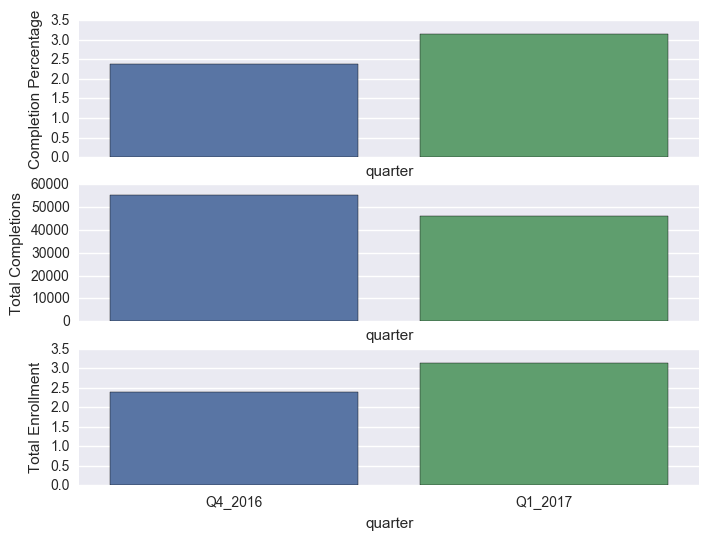

In [78]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

sns.barplot(y="completion_percentage", x="quarter", data=completion_rate_overall_df, ax=ax1)
ax1.set_ylabel("Completion Percentage")

sns.barplot(y="total_completions", x="quarter", data=completion_rate_overall_df, ax=ax2)
ax2.set_ylabel("Total Completions")

sns.barplot(y="completion_percentage", x="quarter", data=completion_rate_overall_df, ax=ax3)
ax3.set_ylabel("Total Enrollment")

## Investigating this on a per course basis
#### Filtered out courses w/fewer than 100 enrollments to keep the long tail managable

#### completion_rate_by_course_df['completion_percentage'] = completion_rate_by_course_df['completion_percentage'].astype(float)
completion_rate_by_course_df = completion_rate_by_course_df[completion_rate_by_course_df['total_enrollments']>100].sort_values(by='completion_percentage', ascending = False)
completion_rate_by_course_df

## Some courses have exceptional performance! Does that make sense? cc Marco, Shelby

## Let's look at the overall distribution

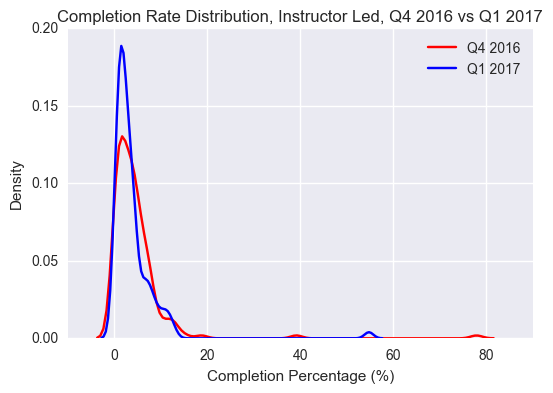

In [80]:
q4_2016 = completion_rate_by_course_df[completion_rate_by_course_df['quarter']=='Q4_2016']
q1_2017 = completion_rate_by_course_df[completion_rate_by_course_df['quarter']=='Q1_2017']
ax = sns.distplot(q4_2016.completion_percentage, color = "r", hist = False, label="Q4 2016")
ax = sns.distplot(q1_2017.completion_percentage, color = "b", hist = False, label="Q1 2017")
ax.set(xlabel='Completion Percentage (%)', ylabel='Density', title='Completion Rate Distribution, Instructor Led, Q4 2016 vs Q1 2017')

## Distributions more or less overlap

* * *
## Let's check course completion as a function of certificate mode to check intuition...

In [21]:
completion_rate_by_course_cert_df['completion_percentage'] = completion_rate_by_course_cert_df['completion_percentage'].astype(float)
completion_rate_by_course_cert_df = completion_rate_by_course_cert_df[completion_rate_by_course_cert_df['total_enrollments']>100].sort_values(by='completion_percentage', ascending = False)
completion_rate_by_course_cert_df

,catalog_course_title,certificate_mode,completion_percentage,course_id,quarter,total_completions,total_enrollments
103,Intellectual Property Law and Policy - Part 2:...,verified,88.646288,course-v1:PennX+IPLAW2x+1T2016,Q4_2016,203.0,229
57,Distributed Machine Learning with Apache Spark,verified,87.009992,course-v1:BerkeleyX+CS120x+2T2016,Q1_2017,1132.0,1301
300,Big Data Analysis with Apache Spark,verified,86.822289,course-v1:BerkeleyX+CS110x+2T2016,Q1_2017,1153.0,1328
168,Introduction to People Management,verified,86.538462,course-v1:IIMBx+HR101x+1T2016,Q4_2016,270.0,312
259,Smart Grids: Electricity for the Future,verified,86.425339,course-v1:IEEEx+SmartGrid.x+2016_T2,Q1_2017,191.0,221
454,HTML5 Part 2: Advanced Techniques for Designin...,verified,86.000000,course-v1:W3Cx+HTML5.2x+1T2016,Q1_2017,129.0,150
295,HTML5 Part 1: HTML5 Coding Essentials and Best...,verified,85.937500,course-v1:W3Cx+HTML5.1x+2T2016,Q1_2017,220.0,256
625,"Digital Marketing, Social Media and E-Commerce...",professional,82.122905,course-v1:Wharton+DigitalMarketing1.1x+1T2016,Q4_2016,147.0,179
140,Innovation and IT Management,verified,81.714286,course-v1:IIMBx+IS110x+2T2016,Q4_2016,143.0,175
564,Enabling Technologies for Data Science and Ana...,verified,79.639175,course-v1:ColumbiaX+DS103x+1T2016,Q4_2016,309.0,388


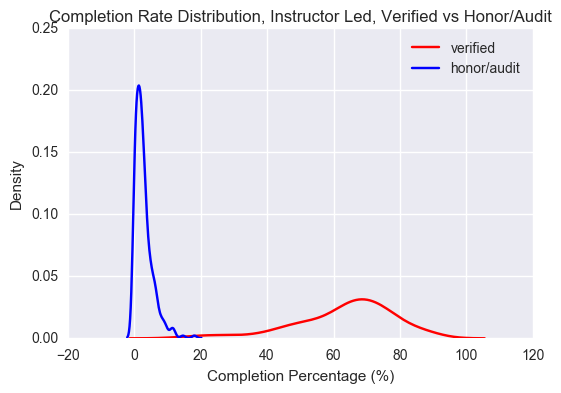

In [82]:
verified = completion_rate_by_course_cert_df[completion_rate_by_course_cert_df['certificate_mode']=='verified']
honor_audit = completion_rate_by_course_cert_df[completion_rate_by_course_cert_df['certificate_mode']=='honor/audit']
ax = sns.distplot(verified.completion_percentage, color = "r", hist = False, label="verified")
ax = sns.distplot(honor_audit.completion_percentage, color = "b", hist = False, label="honor/audit")
ax.set(xlabel='Completion Percentage (%)', ylabel='Density', title='Completion Rate Distribution, Instructor Led, Verified vs Honor/Audit')

## Aha! Much better completion rate for verified track vs honor/audit. Makes sense ($$ == effort).
* * *
## Let's see if number of verified enrollments quarter over quarter is enough to explain the increase in completion rate

In [83]:
completion_rate_by_course_cert_df

,catalog_course_title,certificate_mode,completion_percentage,course_id,quarter,total_completions,total_enrollments
183,Intellectual Property Law and Policy - Part 2:...,verified,88.646288,course-v1:PennX+IPLAW2x+1T2016,Q4_2016,203.0,229
137,Distributed Machine Learning with Apache Spark,verified,87.009992,course-v1:BerkeleyX+CS120x+2T2016,Q1_2017,1132.0,1301
51,Big Data Analysis with Apache Spark,verified,86.822289,course-v1:BerkeleyX+CS110x+2T2016,Q1_2017,1153.0,1328
248,Introduction to People Management,verified,86.538462,course-v1:IIMBx+HR101x+1T2016,Q4_2016,270.0,312
10,Smart Grids: Electricity for the Future,verified,86.425339,course-v1:IEEEx+SmartGrid.x+2016_T2,Q1_2017,191.0,221
454,HTML5 Part 2: Advanced Techniques for Designin...,verified,86.000000,course-v1:W3Cx+HTML5.2x+1T2016,Q1_2017,129.0,150
46,HTML5 Part 1: HTML5 Coding Essentials and Best...,verified,85.937500,course-v1:W3Cx+HTML5.1x+2T2016,Q1_2017,220.0,256
625,"Digital Marketing, Social Media and E-Commerce...",professional,82.122905,course-v1:Wharton+DigitalMarketing1.1x+1T2016,Q4_2016,147.0,179
220,Innovation and IT Management,verified,81.714286,course-v1:IIMBx+IS110x+2T2016,Q4_2016,143.0,175
564,Enabling Technologies for Data Science and Ana...,verified,79.639175,course-v1:ColumbiaX+DS103x+1T2016,Q4_2016,309.0,388


In [85]:
(completion_cert_agg['total_completions']/completion_cert_agg['total_enrollments'])*100.0

certificate_mode    quarter
honor/audit         Q1_2017     1.769103
                    Q4_2016     1.659013
no-id-professional  Q1_2017    61.538462
professional        Q4_2016    82.122905
verified            Q1_2017    68.402418
                    Q4_2016    54.338469
dtype: float64

### ~14% increase in completion rate for verified. ~0.1% bump for honor/audit. 

In [86]:
verif_percentage = (completion_cert_agg.unstack(0)['total_enrollments']['verified']/completion_cert_agg.unstack(0)['total_enrollments'].sum(axis=1)) * 100
verif_percentage

quarter
Q1_2017    1.903398
Q4_2016    1.144667
dtype: float64

### A larger number of percentage of enrollment was verified in Q1 relative to Q4.

* * *
# Next steps
* * *

### * Understand on the course level. Are learners completing the same courses with more frequency over time or is the increase due to different course offerings entirely?

### * Are we prioritizing the right projects for the rest of the year based on what we see here? We could bump up course offerings for those similar to the top end of the completion range and "ignore" the majority that are clustered towards zero. That's essentially what got us the entirety of the increase this quarter.

In [44]:
completion_rate_by_course_query_w_program_df.groupby('subject_title').count()

,catalog_course_title,completion_percentage,course_id,program_type,total_completions,total_enrollments
subject_title,,,,,,
Architecture,3,3,3,0,3,3
Art & Culture,11,11,11,0,11,11
Biology & Life Sciences,20,20,20,0,20,20
Business & Management,25,25,25,5,25,25
Chemistry,4,4,4,0,4,4
Computer Science,32,30,32,12,30,32
Data Analysis & Statistics,12,12,12,7,12,12
Design,2,2,2,1,2,2
Economics & Finance,19,18,19,0,18,19


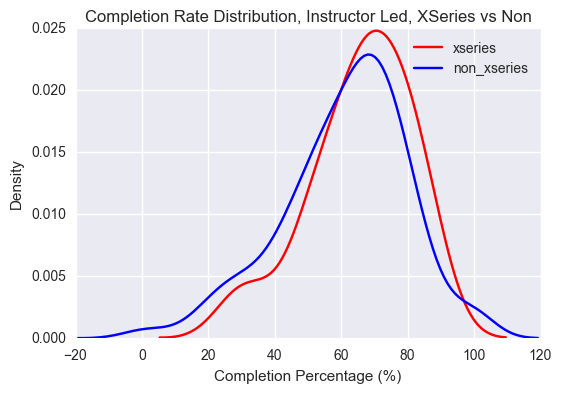

In [20]:
completion_rate_by_course_query_w_program_df_verified = completion_rate_by_course_query_w_program_df[completion_rate_by_course_query_w_program_df['certificate_mode']=='verified']
xseries = completion_rate_by_course_query_w_program_df_verified[completion_rate_by_course_query_w_program_df_verified['program_type']=='XSeries']
non_xseries = completion_rate_by_course_query_w_program_df_verified[completion_rate_by_course_query_w_program_df_verified['program_type']!='XSeries']
ax = sns.distplot(xseries.completion_percentage, color = "r", hist = False, label="xseries")
ax = sns.distplot(non_xseries.completion_percentage, color = "b", hist = False, label="non_xseries")
ax.set(xlabel='Completion Percentage (%)', ylabel='Density', title='Completion Rate Distribution, Instructor Led, XSeries vs Non')

In [261]:
verifications_df.head()

,course_id,subject_title,verified_enrollments
215,HarvardX/CS50x3/2015,None,5607
167,course-v1:MITx+CTL.SC1x_2+1T2016,None,3538
158,course-v1:IDBx+IDB6x+2016_T1,None,3514
114,course-v1:BerkeleyX+CS105x+1T2016,Data Analysis & Statistics,2598
246,course-v1:BerkeleyX+CS105x+1T2016,Computer Science,2598


In [271]:
verifications_df.to_csv('verifications_null_subject.csv')
completed_courses_df.to_csv('completions_null_subject.csv')

# lots of missing stuff. manually filled in on my machine :((

In [273]:
verifications_df = pd.read_csv('verifications_null_subject.csv')
completed_courses_df = pd.read_csv('completions_null_subject.csv')

In [336]:
verifications_df_summarized = verifications_df.groupby('subject_title').sum()['verified_enrollments'].reset_index()
verifications_df_summarized = verifications_df_summarized.sort_values('verified_enrollments', ascending = False)
order_list = verifications_df_summarized['subject_title'].tolist()

In [337]:
verifications_df_summarized['cumulative_enrollment_pct']= verifications_df_summarized.cumsum()['verified_enrollments'].astype(int)*100.0/verifications_df_summarized.sum()['verified_enrollments']

In [338]:
verifications_df_summarized

,subject_title,verified_enrollments,cumulative_enrollment_pct
4,Computer Science,15266,25.971419
3,Business & Management,14997,51.485199
5,Data Analysis & Statistics,6896,63.217081
24,Social Sciences,2692,67.796870
10,Engineering,2628,72.267778
2,Biology & Life Sciences,2570,76.640014
7,Economics & Finance,2385,80.697516
23,Science,1934,83.987751
15,Humanities,1734,86.937734
14,History,1265,89.089826


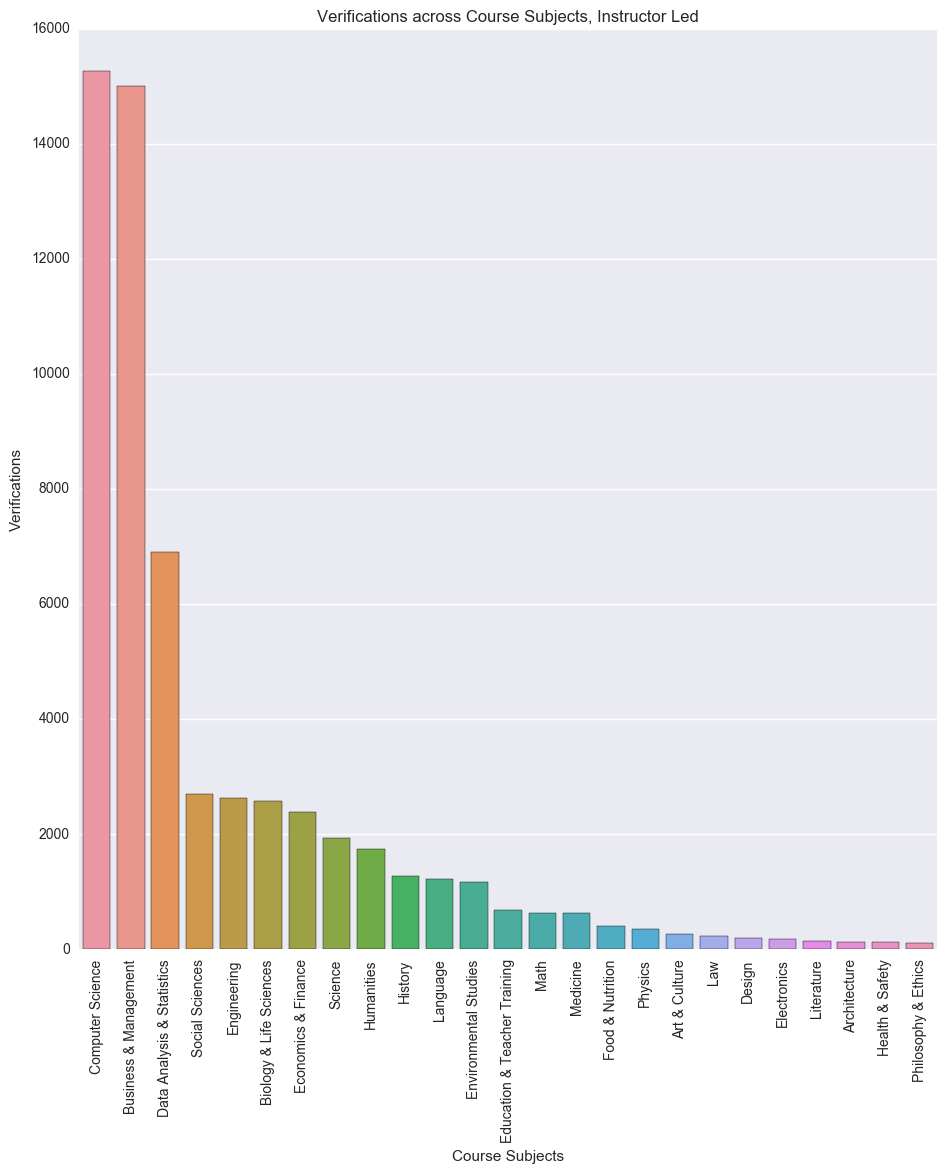

In [458]:
g = sns.factorplot(data = verifications_df_summarized.sort_values('verified_enrollments', ascending = False), x='subject_title', y = 'verified_enrollments', kind='bar', size=10, ci = None)
g.set_xticklabels(rotation = 90)
g.set(xlabel='Course Subjects', ylabel='Verifications', title='Verifications across Course Subjects, Instructor Led')
g.savefig("verifications_by_subject_sum.png")

In [463]:
verifications_df_summarized

,subject_title,verified_enrollments,cumulative_enrollment_pct,percent_overall_verifs
4,Computer Science,15266,25.971419,25.971419
3,Business & Management,14997,51.485199,25.513780
5,Data Analysis & Statistics,6896,63.217081,11.731882
24,Social Sciences,2692,67.796870,4.579789
10,Engineering,2628,72.267778,4.470908
2,Biology & Life Sciences,2570,76.640014,4.372235
7,Economics & Finance,2385,80.697516,4.057503
23,Science,1934,83.987751,3.290235
15,Humanities,1734,86.937734,2.949983
14,History,1265,89.089826,2.152093


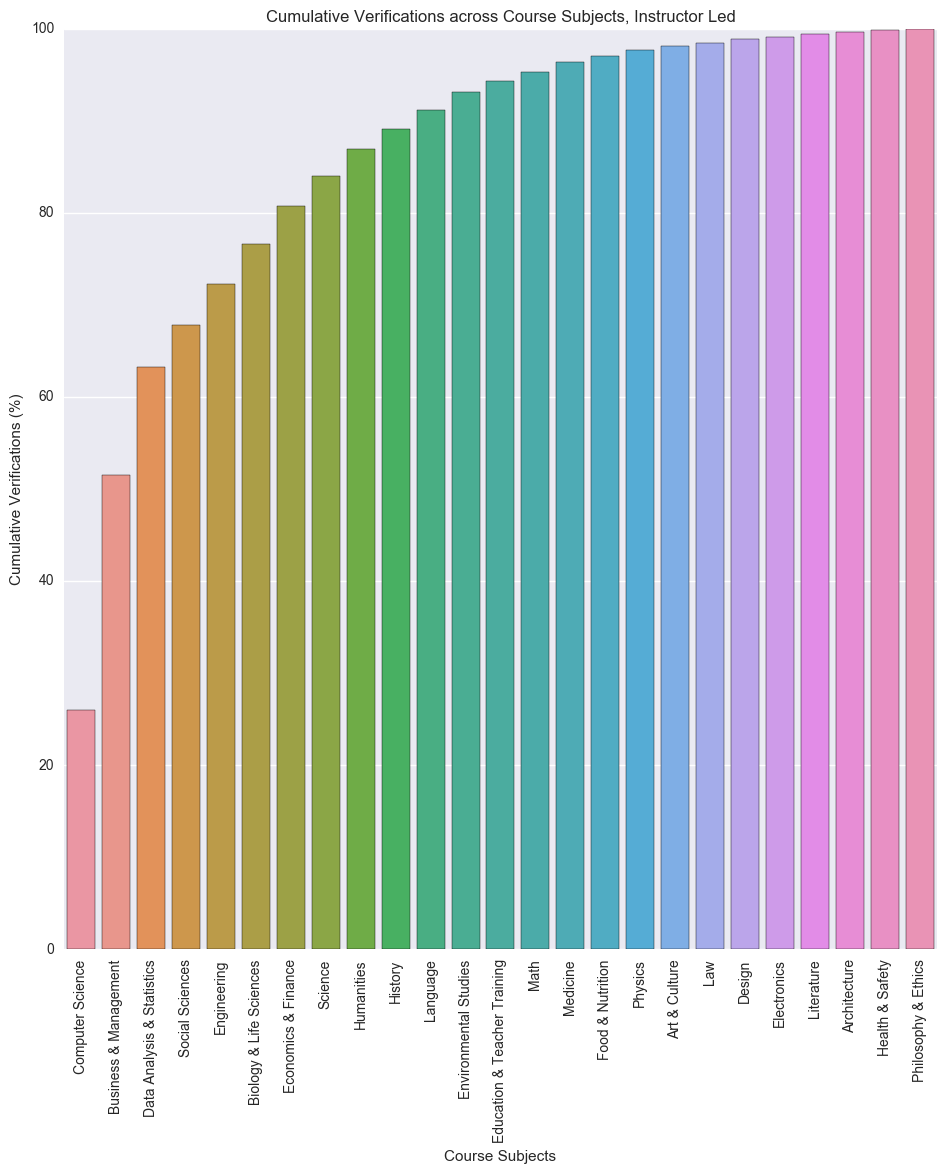

In [459]:
#verifications_df_summarized = verifications_df.groupby('subject_title').sum()['verified_enrollments'].reset_index()
g = sns.factorplot(data = verifications_df_summarized, x='subject_title', y = 'cumulative_enrollment_pct', kind='bar', size=10, ci = None)
g.set_xticklabels(rotation = 90)
g.set(xlabel='Course Subjects', ylabel='Cumulative Verifications (%)', title='Cumulative Verifications across Course Subjects, Instructor Led')
g.savefig("verifications_by_subject_cumulative.png")

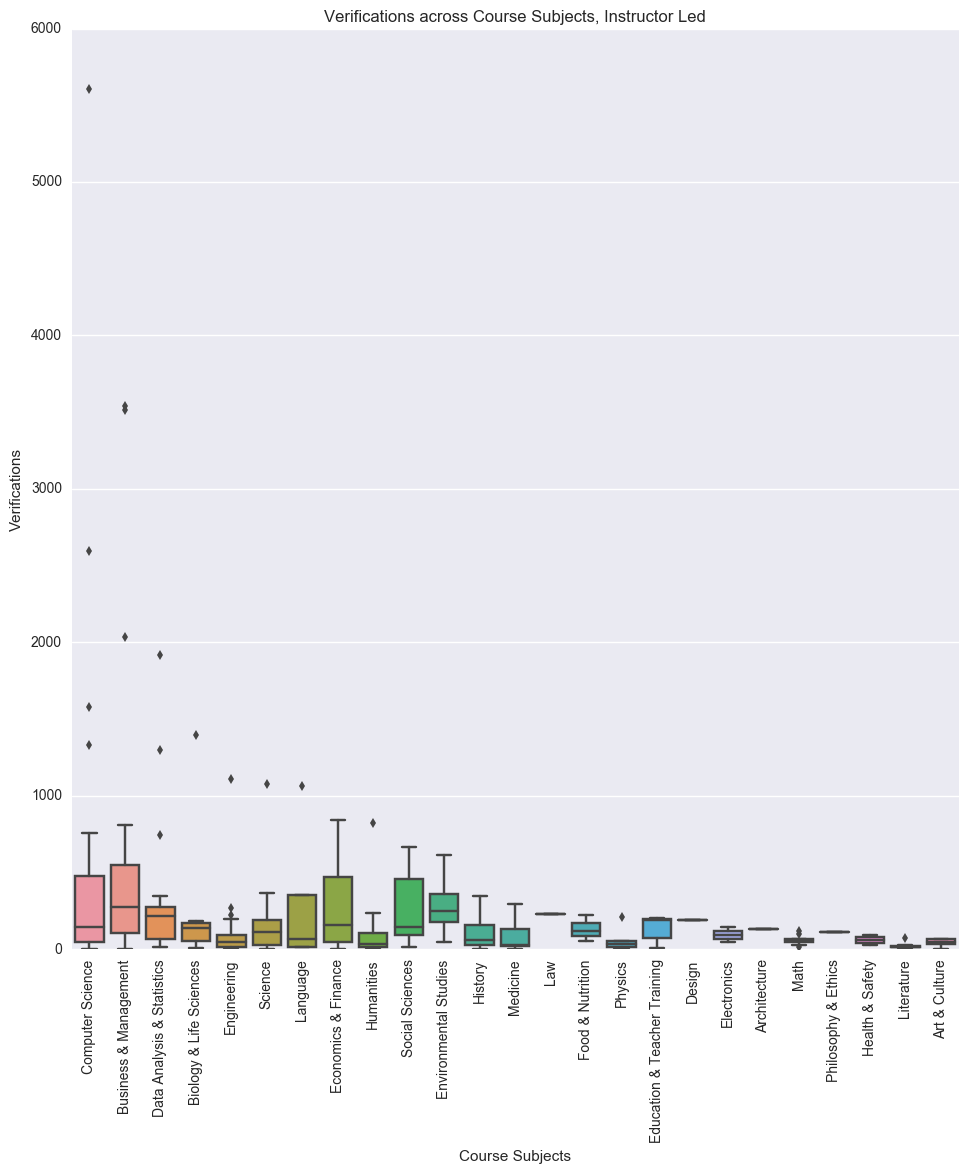

In [460]:
g = sns.factorplot(data = verifications_df.sort_values('verified_enrollments',ascending = False), x='subject_title', y = 'verified_enrollments', kind='box', size = 10)
g.set_xticklabels(rotation = 90)
g.set(xlabel='Course Subjects', ylabel='Verifications', title='Verifications across Course Subjects, Instructor Led')
g.savefig("verifications_by_subject_course_distribution.png")

In [351]:
completed_courses_consolidated_df = (completed_courses_df.groupby(['subject_title','course_id']).sum()['completed_courses']*100.0/completed_courses_df.groupby(['subject_title','course_id']).sum()['course_enrollments']).reset_index()

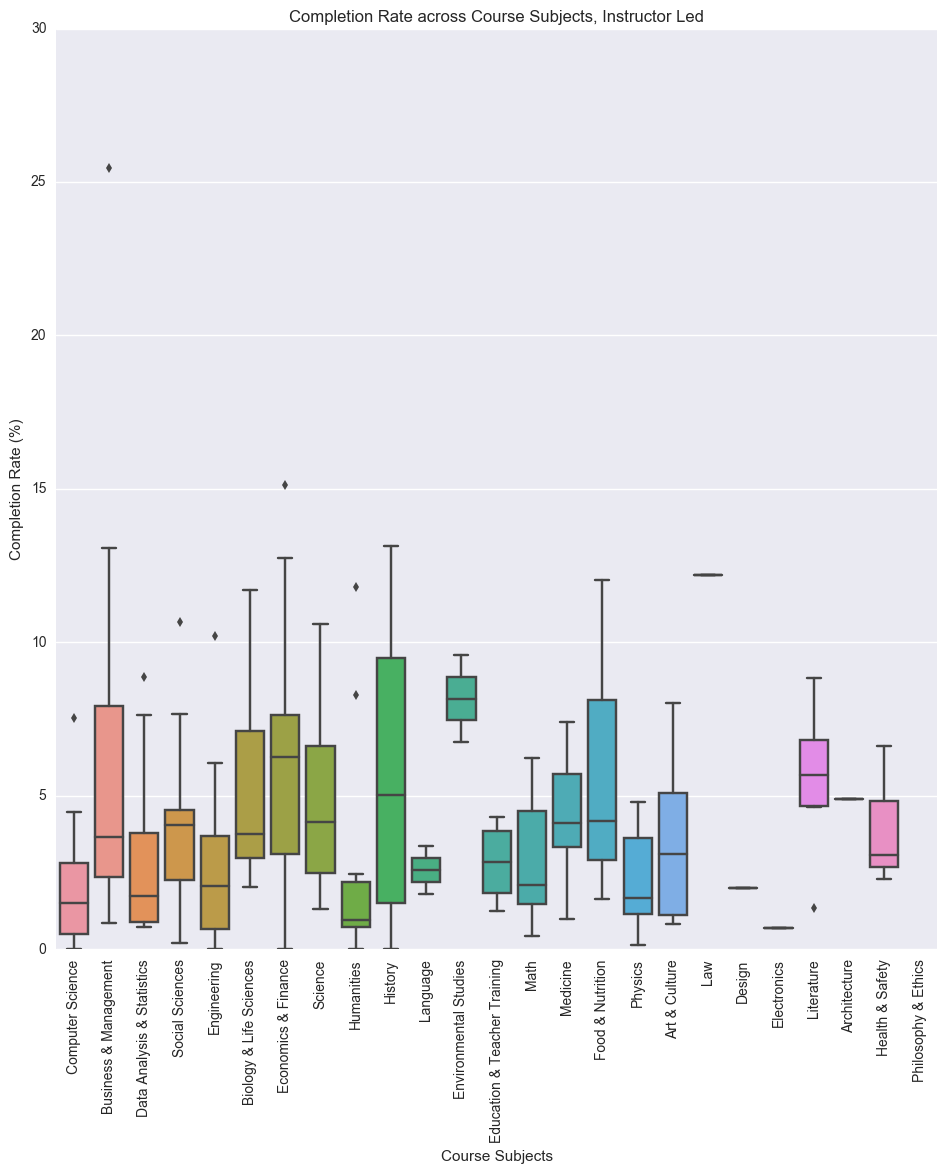

In [354]:
g = sns.factorplot(data = completed_courses_consolidated_df.reset_index().sort_values(0, ascending = False), x='subject_title', y = 0,
                   kind='box', size=10, order = order_list)
g.set_xticklabels(rotation = 90)
g.set(xlabel='Course Subjects', ylabel='Completion Rate (%)', title='Completion Rate across Course Subjects, Instructor Led')
g.savefig("completion_rate_by_subject_course_distribution.png")

In [467]:
completed_courses_df.groupby('subject_title').sum()

,Unnamed: 0,completed_courses,course_enrollments,rank
subject_title,,,,
Architecture,53,221,4514,1
Art & Culture,1022,776,28510,6
Biology & Life Sciences,2260,4525,78464,12
Business & Management,3853,20128,375372,25
Chemistry,834,549,24427,4
Computer Science,3871,13670,1308808,28
Data Analysis & Statistics,2463,11086,302260,19
Design,163,266,13259,1
Economics & Finance,1290,4856,75258,10


In [376]:
course_count = completed_courses_df.groupby('subject_title').count()
#course_count.reset_index().sort(order_list)

In [386]:
course_count = course_count.reset_index()
course_count['subject_title'] = pd.Categorical(course_count['subject_title'], order_list)

In [390]:
course_count= course_count.sort_values('subject_title')
course_count = course_count[pd.notnull(course_count['subject_title'])]

In [394]:
course_count

,subject_title,Unnamed: 0,completed_courses,course_enrollments,course_id,rank
5,Computer Science,28,28,28,28,28
3,Business & Management,25,25,25,25,25
6,Data Analysis & Statistics,19,19,19,19,19
25,Social Sciences,12,12,12,12,12
12,Engineering,22,22,22,22,22
2,Biology & Life Sciences,12,12,12,12,12
8,Economics & Finance,10,10,10,10,10
24,Science,10,10,10,10,10
17,Humanities,12,12,12,12,12
16,History,10,10,10,10,10


In [401]:
course_count['cumulative_courses_offered'] = course_count['course_enrollments'].cumsum().astype(int)*100.0/course_count.sum()['course_enrollments']

In [464]:
course_count

,subject_title,Unnamed: 0,completed_courses,course_enrollments,course_id,rank,cumulative_courses_offered,percent_overall_courses
5,Computer Science,28,28,28,28,28,13.023256,13.023256
3,Business & Management,25,25,25,25,25,24.651163,11.627907
6,Data Analysis & Statistics,19,19,19,19,19,33.488372,8.837209
25,Social Sciences,12,12,12,12,12,39.069767,5.581395
12,Engineering,22,22,22,22,22,49.302326,10.232558
2,Biology & Life Sciences,12,12,12,12,12,54.883721,5.581395
8,Economics & Finance,10,10,10,10,10,59.534884,4.651163
24,Science,10,10,10,10,10,64.186047,4.651163
17,Humanities,12,12,12,12,12,69.767442,5.581395
16,History,10,10,10,10,10,74.418605,4.651163


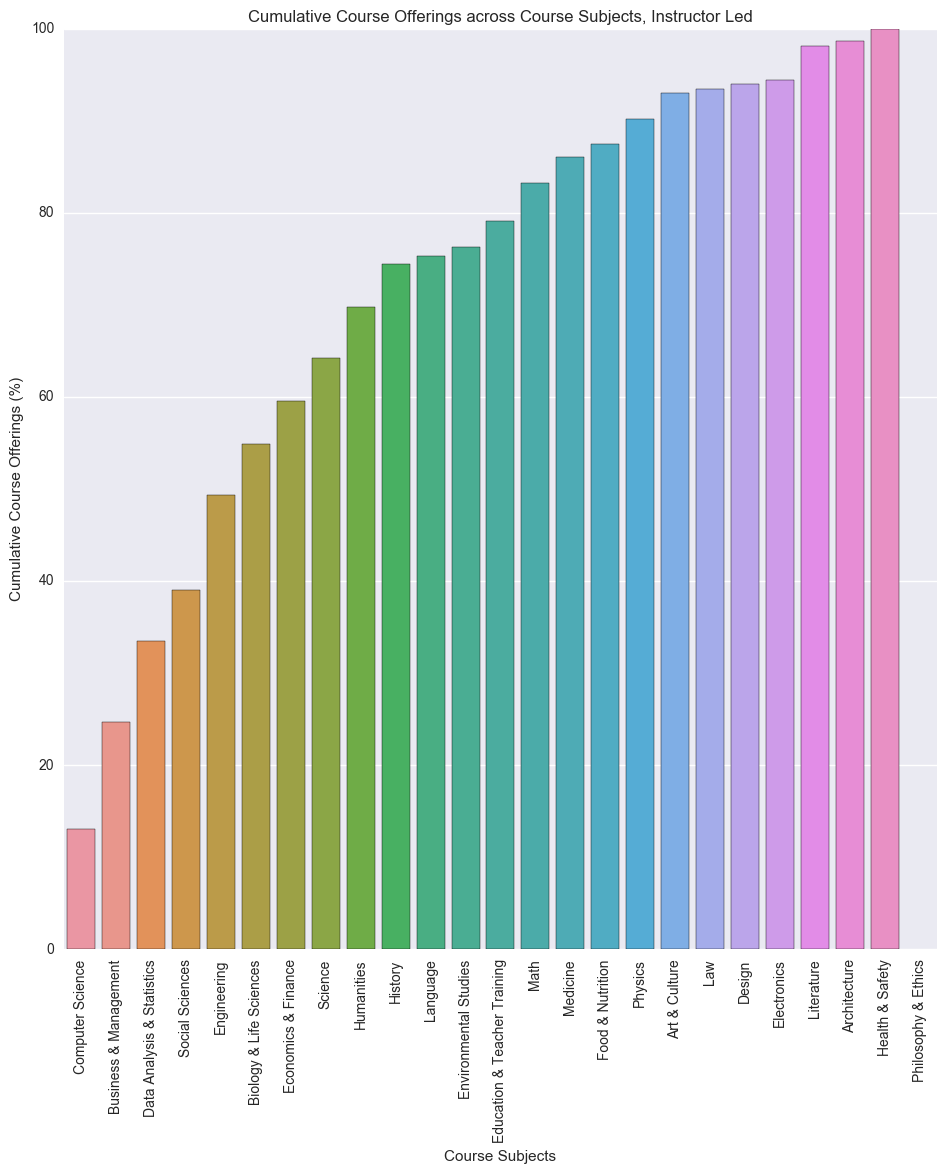

In [461]:
g = sns.factorplot(data = course_count, x='subject_title', y = 'cumulative_courses_offered', kind='bar', size=10, ci = None)
g.set_xticklabels(rotation = 90)
g.set(xlabel='Course Subjects', ylabel='Cumulative Course Offerings (%)', title='Cumulative Course Offerings across Course Subjects, Instructor Led')
g.savefig("percent_overall_courses_offered_by_subject.png")

In [405]:
course_count

,subject_title,Unnamed: 0,completed_courses,course_enrollments,course_id,rank,cumulative_courses_offered
5,Computer Science,28,28,28,28,28,13.023256
3,Business & Management,25,25,25,25,25,24.651163
6,Data Analysis & Statistics,19,19,19,19,19,33.488372
25,Social Sciences,12,12,12,12,12,39.069767
12,Engineering,22,22,22,22,22,49.302326
2,Biology & Life Sciences,12,12,12,12,12,54.883721
8,Economics & Finance,10,10,10,10,10,59.534884
24,Science,10,10,10,10,10,64.186047
17,Humanities,12,12,12,12,12,69.767442
16,History,10,10,10,10,10,74.418605


In [422]:
verifications_df_summarized['percent_overall_verifs'] = verifications_df_summarized['verified_enrollments']*100.0/verifications_df_summarized.sum()['verified_enrollments']
course_count['percent_overall_courses'] = course_count['course_id']*100.0/course_count.sum()['course_id']
joint_cumulative_df = (verifications_df_summarized.set_index('subject_title')).join(course_count.set_index('subject_title'))

In [423]:
joint_cumulative_df

,verified_enrollments,cumulative_enrollment_pct,percent_overall_verifs,Unnamed: 0,completed_courses,course_enrollments,course_id,rank,cumulative_courses_offered,percent_overall_courses
subject_title,,,,,,,,,,
Computer Science,15266,25.971419,25.971419,28.0,28.0,28.0,28.0,28.0,13.023256,13.023256
Business & Management,14997,51.485199,25.513780,25.0,25.0,25.0,25.0,25.0,24.651163,11.627907
Data Analysis & Statistics,6896,63.217081,11.731882,19.0,19.0,19.0,19.0,19.0,33.488372,8.837209
Social Sciences,2692,67.796870,4.579789,12.0,12.0,12.0,12.0,12.0,39.069767,5.581395
Engineering,2628,72.267778,4.470908,22.0,22.0,22.0,22.0,22.0,49.302326,10.232558
Biology & Life Sciences,2570,76.640014,4.372235,12.0,12.0,12.0,12.0,12.0,54.883721,5.581395
Economics & Finance,2385,80.697516,4.057503,10.0,10.0,10.0,10.0,10.0,59.534884,4.651163
Science,1934,83.987751,3.290235,10.0,10.0,10.0,10.0,10.0,64.186047,4.651163
Humanities,1734,86.937734,2.949983,12.0,12.0,12.0,12.0,12.0,69.767442,5.581395


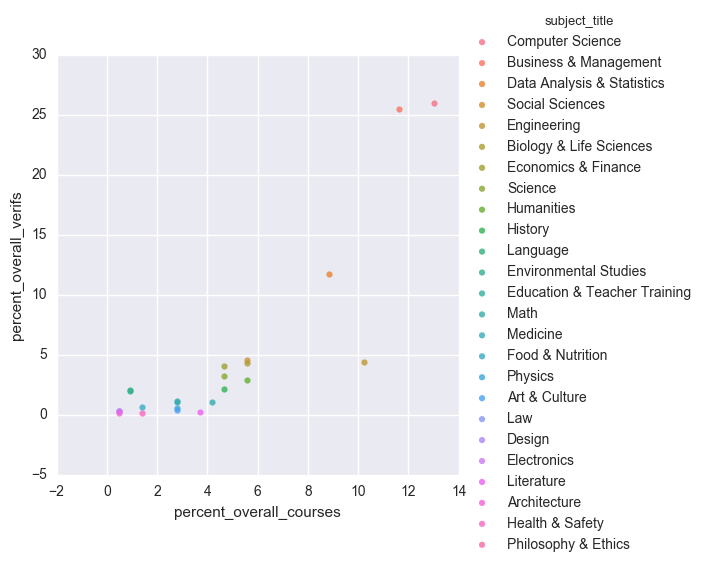

In [462]:
g = sns.lmplot(data=joint_cumulative_df.reset_index(), x = 'percent_overall_courses', y = 'percent_overall_verifs',
           hue = 'subject_title', legend = True, fit_reg = False)
g.savefig("percent_overall_verifs_vs_percent_overall_courses.png")
#g.plot(x,y)#(data = ref_df.reset_index(), x = 'index', y='A')

In [465]:
joint_cumulative_df

,verified_enrollments,cumulative_enrollment_pct,percent_overall_verifs,Unnamed: 0,completed_courses,course_enrollments,course_id,rank,cumulative_courses_offered,percent_overall_courses
subject_title,,,,,,,,,,
Computer Science,15266,25.971419,25.971419,28.0,28.0,28.0,28.0,28.0,13.023256,13.023256
Business & Management,14997,51.485199,25.513780,25.0,25.0,25.0,25.0,25.0,24.651163,11.627907
Data Analysis & Statistics,6896,63.217081,11.731882,19.0,19.0,19.0,19.0,19.0,33.488372,8.837209
Social Sciences,2692,67.796870,4.579789,12.0,12.0,12.0,12.0,12.0,39.069767,5.581395
Engineering,2628,72.267778,4.470908,22.0,22.0,22.0,22.0,22.0,49.302326,10.232558
Biology & Life Sciences,2570,76.640014,4.372235,12.0,12.0,12.0,12.0,12.0,54.883721,5.581395
Economics & Finance,2385,80.697516,4.057503,10.0,10.0,10.0,10.0,10.0,59.534884,4.651163
Science,1934,83.987751,3.290235,10.0,10.0,10.0,10.0,10.0,64.186047,4.651163
Humanities,1734,86.937734,2.949983,12.0,12.0,12.0,12.0,12.0,69.767442,5.581395
